# Get Error of EMS Predictions

1. Get all models 
2. Train model
3. Predict on testset
4. Calc Errors

## Notebook Preps

In [1]:
%load_ext autoreload
%autoreload 2
%load_ext dotenv
%dotenv

In [2]:
# change current directory to the project directory
import os
os.chdir('../../../')

In [3]:
!pip install -r ai/requirements.txt --user
#!pip install plotly
#!pip install matplotlib
#!pip install seaborn
!pip install python-dotenv

  Using cached APScheduler-3.10.4-py3-none-any.whl (59 kB)
  Using cached holidays-0.35-py3-none-any.whl (800 kB)
  Using cached optuna-3.3.0-py3-none-any.whl (404 kB)
  Using cached pandas-2.1.1-cp311-cp311-win_amd64.whl (10.6 MB)
  Using cached paramiko-3.3.1-py3-none-any.whl (224 kB)
  Using cached sanic-23.6.0-py3-none-any.whl (202 kB)
  Using cached types_paramiko-3.3.0.0-py3-none-any.whl (33 kB)
  Attempting uninstall: sanic
    Found existing installation: sanic 23.3.0
    Uninstalling sanic-23.3.0:
      Successfully uninstalled sanic-23.3.0
  Attempting uninstall: pandas
    Found existing installation: pandas 1.5.3
    Uninstalling pandas-1.5.3:
      Successfully uninstalled pandas-1.5.3


ERROR: Could not install packages due to an OSError: [WinError 5] Access is denied: 'C:\\Users\\jpeff\\AppData\\Roaming\\Python\\Python311\\site-packages\\~andas\\_libs\\algos.cp311-win_amd64.pyd'
Check the permissions.


[notice] A new release of pip available: 22.3.1 -> 23.3.2
[notice] To update, run: python.exe -m pip install --upgrade pip



[notice] A new release of pip available: 22.3.1 -> 23.3.2
[notice] To update, run: python.exe -m pip install --upgrade pip


First let's set environment variables. (in .env file in ai folder) (Note: also run the proxy script) Example would be

```env
CLUSTER_NAME=dev
DB_USER=asdf
DB_PASS=asdf
DB_ADDR=127.0.0.1
DB_PORT=5432
DB_NAME=lynus
DB_MODE=disable
S3_ENDPOINT=sos-at-vie-1.exo.io
S3_ACCESS_KEY=asdf
S3_SECRET_KEY=asdf
S3_SECURE=1
EMPA_ADDR=http://127.0.0.1:9000/
WEATHER_API_KEY=asdf
```

In [4]:
from dotenv import load_dotenv

load_dotenv("./ai/.env.bms", override=True)

True

## EMS Testing

### Fetch all Models

In [67]:
import psycopg
import pandas as pd

# Get DB connection and all EMS models

try:
    # Establish a connection to the PostgreSQL database
    connection = psycopg.connect(
        dbname=os.environ["DB_NAME"],
        user=os.environ["DB_USER"],
        password=os.environ["DB_PASS"],
        host=os.environ["DB_ADDR"],
        port=os.environ["DB_PORT"]
    )

    # Create a cursor object to interact with the database
    cursor = connection.cursor()

    cursor.execute("SELECT models.id as model_id, models.r->'data'->>'type' as model_type, project.name as project_name, models.r->>'project_id' as project_id \
FROM models \
JOIN project ON models.r->>'project_id'= project.id::text \
WHERE models.r -> 'data' ->> 'type' LIKE '%EMS%' \
")
    result = cursor.fetchall()
    columns = [desc[0] for desc in cursor.description]  # Get column names
    

except psycopg.Error as e:
    print(f"Unable to connect to the database. Error: {e}")

finally:
    # Close the cursor and connection, regardless of whether the try block succeeds or raises an exception
    if connection:
        cursor.close()
        connection.close()
        print("Connection closed.")

# Convert the result to a Pandas DataFrame
model_df = pd.DataFrame(result, columns=columns)
model_df

Connection closed.


,model_id,model_type,project_name,project_id
0,d9cdab3e-acd9-499b-b53c-05d698b23b95,EMS,Projekt Hammerschmied,673dfecd-87ae-41b4-adc6-bf4a9ec1d31b
1,a2281880-cb84-4705-a09d-f80367bdd342,EMS,Mayrhofer,e51c2607-26db-4106-b5ea-e880014dacba
2,0ed1bfca-b33e-4063-a907-d5ebe85bb622,EMS,Barac Michael,c4f8afbf-2040-4517-95e7-ed7f0d999242
3,4d908d4d-b57d-47e8-ab5a-738326e72be9,EMS,HAPU,b818e25e-2206-4375-bd9d-0099f6e8c3ab
4,660decfe-1fe8-4c3d-b6ea-f29d22697d94,EMS,HAPU,b818e25e-2206-4375-bd9d-0099f6e8c3ab
5,9d79ac11-63df-45ad-82a2-0075652d0506,EMS,Feigl,f2612c04-11b1-4280-957b-bcd7afeefd1d
6,99582f62-bad3-4bbb-8ff6-42d9f0827a1f,EMS,Projekt Kogler,f78d81b3-e56c-4072-b5bd-ca591893463c
7,15334478-785b-4345-8a88-cc748e9abcb7,EMS,Jodlbauer,189e4327-6e6d-4ffb-9c03-09f2cb3fc9e8
8,fd2f03d2-099b-45e3-b300-b01853e06f00,EMS,Brandmoa,32673a79-600a-4644-a67c-4e88e91f75b0
9,d1793fbb-e453-4a38-a37d-235e0111afe1,EMS,Projekt Katzenhofer,9c801c0d-8c2c-4278-a890-f6835690b001


### Functions used in this Notebook

In [68]:
import datetime
from ai.model.ems_model import EmsModel
from ai.preprocessing.ems_preprocessing import preprocess_ems_data, get_ems_features
from ai.interface.model_holder import ModelHolder
from ai.model_holder.ems_model_holder import EmsModelHolder

# Get start and end time to create train and test set


index = 0
train_duration_weeks = 5

model_id = str(model_df.iloc[index]["model_id"])
model_holder_type = EmsModelHolder
model_holder = ModelHolder.load_model_holder_from_s3(model_id, model_holder_type, model_load=False)

end = datetime.datetime.now()  - datetime.timedelta(days=2)    
start = datetime.datetime.fromtimestamp(model_holder.get_start())

if (end - start) <= datetime.timedelta(days=14):
    raise ValueError("Too few data (< 14 days) for EMS training!")

if end - start > datetime.timedelta(weeks=train_duration_weeks):
    start = end - datetime.timedelta(weeks=train_duration_weeks)            
end_training = end - datetime.timedelta(weeks=1)



import seaborn as sns
import matplotlib.pyplot as plt

palette = [
'#03e0b5',
'#24AD92',
'#327A6C',
'#2C4742',
'#293331',]

# Plot errors
def plot_errors(error_dict, prefix):
    fig, axes = plt.subplots(nrows=1, ncols=len(error_dict), figsize=(18, 6), sharey=False)
    for i, (key, value) in enumerate(error_dict.items()):
        
        # Extract keys and values from the dictionary
        model_names = list(value.keys())
        errors = list(value.values())

        # Create a bar chart using seaborn
        sns.set(style="white")
        plt.figure(figsize=(10, 6))
        axes[i].set_title(f'{model_df.iloc[index]["project_name"]} {key} {train_duration_weeks}-weeks')

        ax = sns.barplot(x=model_names, ax=axes[i], y=errors, palette=palette, hue=errors)
        ax.legend_.remove()
        ax.set_xticklabels(ax.get_xticklabels(), rotation=45, horizontalalignment='right')
        for p in ax.patches:
            if p.get_width() == p.get_height() == 0:
                continue
            
            ax.text(p.get_x() + p.get_width()/2., p.get_height(), '{0:.2f}'.format(p.get_height()), 
            fontsize=12, color=p.get_facecolor(), ha='center', va='bottom')
    fig.suptitle(prefix)
    fig.savefig(f"{prefix}_{model_df.iloc[index]['project_name']}_dur-{train_duration_weeks}.png")
    return fig


Preprocess Data

In [69]:
df = model_holder.get_dh().get_data(int(start.timestamp()), int(end_training.timestamp()))
df = preprocess_ems_data(df, 15, True)

(x, y_consumption, y_pv, y_generator, y_grid, y_battery,
        y_charge, y_house, y_electric, y_pump, y_consumer,
        y_soc, y_tpow_battery, y_tpow_charge, y_tpow_electric, y_tpow_pump,
        y_tpow_consumer, recursive) = get_ems_features(
        df,
        lag_steps=[15, 30, 45, 60],
        prediction_steps=[15, 30, 45, 60],
        time_resolution=15,
        lag_label=[15])


Get eval data

In [70]:
df_eval = model_holder.get_dh().get_data(
                int(end_training.timestamp()), int(end.timestamp()))


### Benchmarking

#### Current EMS

In [71]:
# Fit model
from ai.model.ems_model import EmsModel
model_rf = EmsModel()
model_rf.fit(x, y_consumption, y_pv, y_generator, y_grid, y_battery, y_charge,
            y_house, y_electric, y_pump, y_consumer, y_soc, y_tpow_battery,
            y_tpow_charge, y_tpow_electric, y_tpow_pump, y_tpow_consumer, recursive)

In [72]:
errors_rf = model_rf.evaluate(df_eval)

C:\Users\jpeff\AppData\Local\Temp\ipykernel_38660\4003282145.py:53: UserWarning: 
The palette list has fewer values (5) than needed (7) and will cycle, which may produce an uninterpretable plot.
  ax = sns.barplot(x=model_names, ax=axes[i], y=errors, palette=palette, hue=errors)
C:\Users\jpeff\AppData\Local\Temp\ipykernel_38660\4003282145.py:55: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(ax.get_xticklabels(), rotation=45, horizontalalignment='right')
C:\Users\jpeff\AppData\Local\Temp\ipykernel_38660\4003282145.py:53: UserWarning: 
The palette list has fewer values (5) than needed (10) and will cycle, which may produce an uninterpretable plot.
  ax = sns.barplot(x=model_names, ax=axes[i], y=errors, palette=palette, hue=errors)
C:\Users\jpeff\AppData\Local\Temp\ipykernel_38660\4003282145.py:55: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after

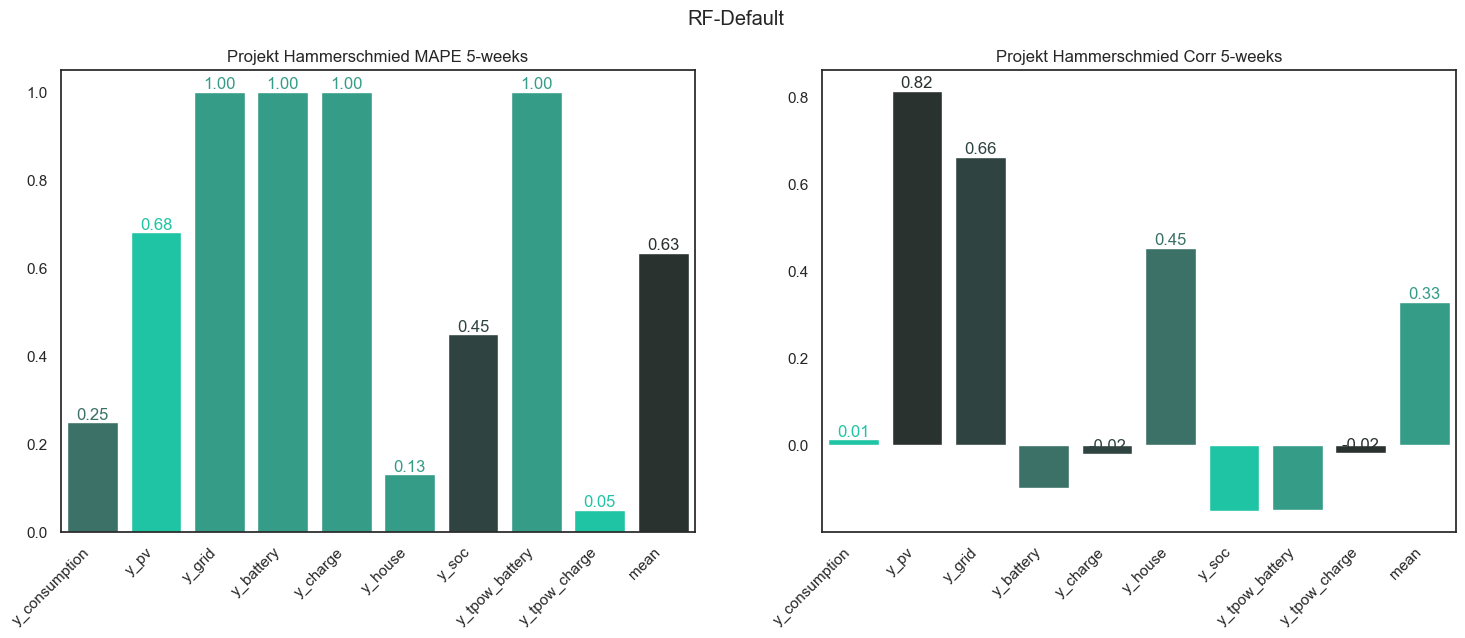

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

In [73]:
plot_rf = plot_errors(errors_rf, "RF-Default")

#### XGBoost

In [74]:
# trying xgboost
import xgboost as xgb
# Fit model
model_xg = EmsModel(custom_regressor=xgb.XGBRegressor, custom_regressor_args={"objective":"reg:squarederror", "random_state":42})
model_xg.fit(x, y_consumption, y_pv, y_generator, y_grid, y_battery, y_charge,
            y_house, y_electric, y_pump, y_consumer, y_soc, y_tpow_battery,
            y_tpow_charge, y_tpow_electric, y_tpow_pump, y_tpow_consumer, recursive)


C:\Users\jpeff\AppData\Roaming\Python\Python311\site-packages\xgboost\data.py:335: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(dtype):
C:\Users\jpeff\AppData\Roaming\Python\Python311\site-packages\xgboost\data.py:338: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  is_categorical_dtype(dtype) or is_pa_ext_categorical_dtype(dtype)
C:\Users\jpeff\AppData\Roaming\Python\Python311\site-packages\xgboost\data.py:384: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if is_categorical_dtype(dtype):
C:\Users\jpeff\AppData\Roaming\Python\Python311\site-packages\xgboost\data.py:359: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) ins

C:\Users\jpeff\AppData\Roaming\Python\Python311\site-packages\xgboost\data.py:335: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(dtype):
C:\Users\jpeff\AppData\Roaming\Python\Python311\site-packages\xgboost\data.py:338: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  is_categorical_dtype(dtype) or is_pa_ext_categorical_dtype(dtype)
C:\Users\jpeff\AppData\Roaming\Python\Python311\site-packages\xgboost\data.py:384: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if is_categorical_dtype(dtype):
C:\Users\jpeff\AppData\Roaming\Python\Python311\site-packages\xgboost\data.py:359: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) ins

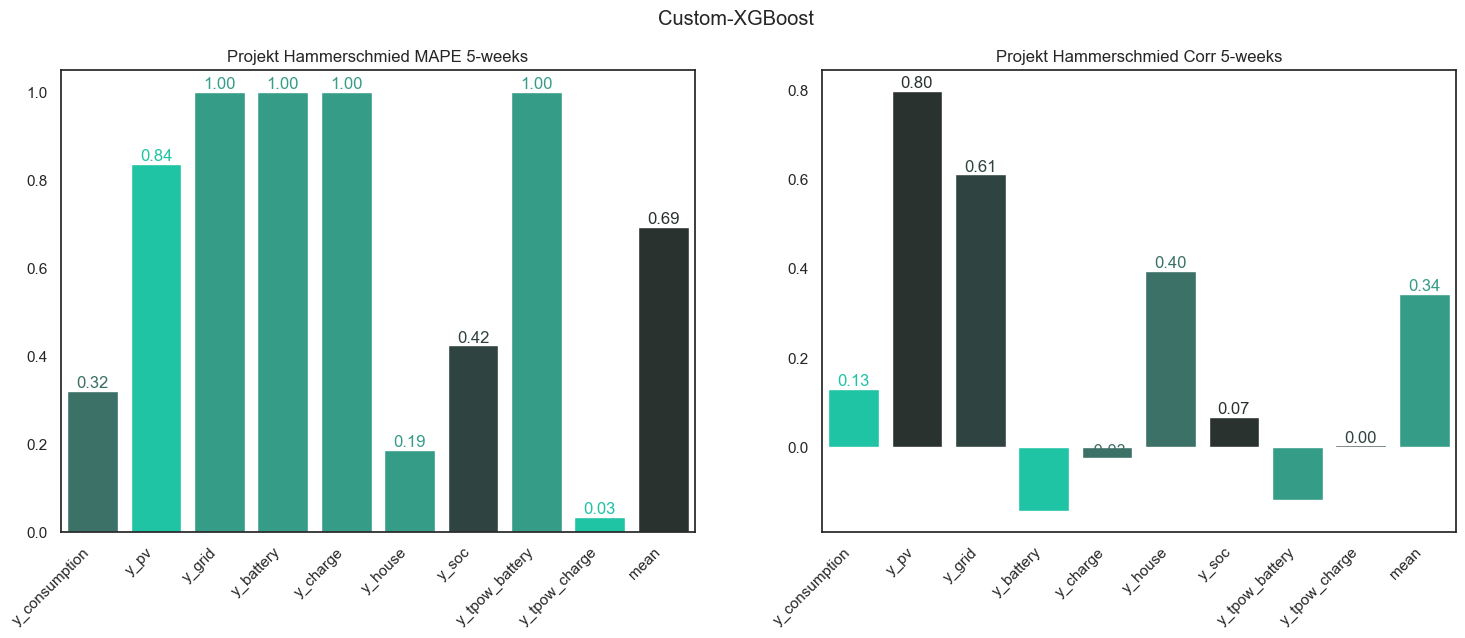

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

In [75]:
errors_xg = model_xg.evaluate(df_eval)
plot_xg = plot_errors(errors_xg, "Custom-XGBoost")

#### Current Implemented Recurrent Random Forest (w XGB)

In [57]:
# Fit model
model_rxg = EmsModel(model_type=1)
model_rxg.fit(x, y_consumption, y_pv, y_generator, y_grid, y_battery, y_charge,
            y_house, y_electric, y_pump, y_consumer, y_soc, y_tpow_battery,
            y_tpow_charge, y_tpow_electric, y_tpow_pump, y_tpow_consumer, recursive)

C:\Users\jpeff\AppData\Roaming\Python\Python311\site-packages\xgboost\data.py:335: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(dtype):
C:\Users\jpeff\AppData\Roaming\Python\Python311\site-packages\xgboost\data.py:338: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  is_categorical_dtype(dtype) or is_pa_ext_categorical_dtype(dtype)
C:\Users\jpeff\AppData\Roaming\Python\Python311\site-packages\xgboost\data.py:384: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if is_categorical_dtype(dtype):
C:\Users\jpeff\AppData\Roaming\Python\Python311\site-packages\xgboost\data.py:359: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) ins

C:\Users\jpeff\AppData\Roaming\Python\Python311\site-packages\xgboost\data.py:335: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(dtype):
C:\Users\jpeff\AppData\Roaming\Python\Python311\site-packages\xgboost\data.py:338: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  is_categorical_dtype(dtype) or is_pa_ext_categorical_dtype(dtype)
C:\Users\jpeff\AppData\Roaming\Python\Python311\site-packages\xgboost\data.py:384: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if is_categorical_dtype(dtype):
C:\Users\jpeff\AppData\Roaming\Python\Python311\site-packages\xgboost\data.py:359: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) ins

In [59]:
errors_rxg = model_rxg.evaluate(df_eval)
plot_rxg = plot_errors(errors_rxg, "RXG")

AttributeError: 'XGBRegressor' object has no attribute 'best_ntree_limit'

#### Tweedie Regression

In [76]:
# GLM
from sklearn.linear_model import TweedieRegressor

# Fit model
model_glm = EmsModel(custom_regressor=TweedieRegressor, custom_regressor_args={})
model_glm.fit(x, y_consumption, y_pv, y_generator, y_grid, y_battery, y_charge,
            y_house, y_electric, y_pump, y_consumer, y_soc, y_tpow_battery,
            y_tpow_charge, y_tpow_electric, y_tpow_pump, y_tpow_consumer, recursive)

C:\Users\jpeff\AppData\Roaming\Python\Python311\site-packages\sklearn\linear_model\_glm\glm.py:282: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res)
C:\Users\jpeff\AppData\Roaming\Python\Python311\site-packages\sklearn\linear_model\_glm\glm.py:282: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res)
C:\Users\jpeff\AppData\Roaming\Python\Python311\site-packages\sklearn\linear_model\_glm\glm.py:282: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT

C:\Users\jpeff\AppData\Local\Temp\ipykernel_38660\4003282145.py:53: UserWarning: 
The palette list has fewer values (5) than needed (7) and will cycle, which may produce an uninterpretable plot.
  ax = sns.barplot(x=model_names, ax=axes[i], y=errors, palette=palette, hue=errors)
C:\Users\jpeff\AppData\Local\Temp\ipykernel_38660\4003282145.py:55: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(ax.get_xticklabels(), rotation=45, horizontalalignment='right')
C:\Users\jpeff\AppData\Local\Temp\ipykernel_38660\4003282145.py:53: UserWarning: 
The palette list has fewer values (5) than needed (10) and will cycle, which may produce an uninterpretable plot.
  ax = sns.barplot(x=model_names, ax=axes[i], y=errors, palette=palette, hue=errors)
C:\Users\jpeff\AppData\Local\Temp\ipykernel_38660\4003282145.py:55: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after

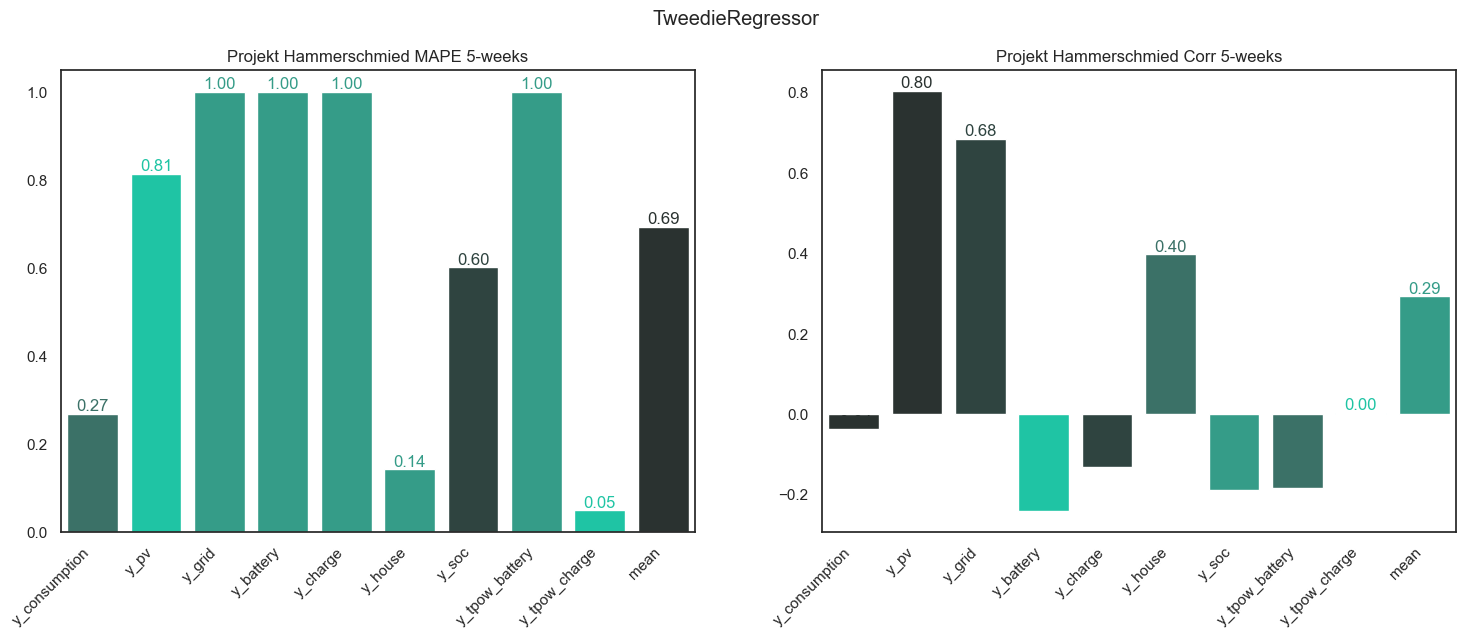

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

In [77]:
errors_glm = model_glm.evaluate(df_eval)
plot_glm = plot_errors(errors_glm, "TweedieRegressor")

#### Support Vector Regression

In [78]:
from sklearn import svm

# Fit model
model_svm = EmsModel(custom_regressor=svm.SVR, custom_regressor_args={})
model_svm.fit(x, y_consumption, y_pv, y_generator, y_grid, y_battery, y_charge,
            y_house, y_electric, y_pump, y_consumer, y_soc, y_tpow_battery,
            y_tpow_charge, y_tpow_electric, y_tpow_pump, y_tpow_consumer, recursive)

C:\Users\jpeff\AppData\Local\Temp\ipykernel_38660\4003282145.py:53: UserWarning: 
The palette list has fewer values (5) than needed (9) and will cycle, which may produce an uninterpretable plot.
  ax = sns.barplot(x=model_names, ax=axes[i], y=errors, palette=palette, hue=errors)
C:\Users\jpeff\AppData\Local\Temp\ipykernel_38660\4003282145.py:55: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(ax.get_xticklabels(), rotation=45, horizontalalignment='right')
C:\Users\jpeff\AppData\Local\Temp\ipykernel_38660\4003282145.py:53: UserWarning: 
The palette list has fewer values (5) than needed (10) and will cycle, which may produce an uninterpretable plot.
  ax = sns.barplot(x=model_names, ax=axes[i], y=errors, palette=palette, hue=errors)
C:\Users\jpeff\AppData\Local\Temp\ipykernel_38660\4003282145.py:55: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after

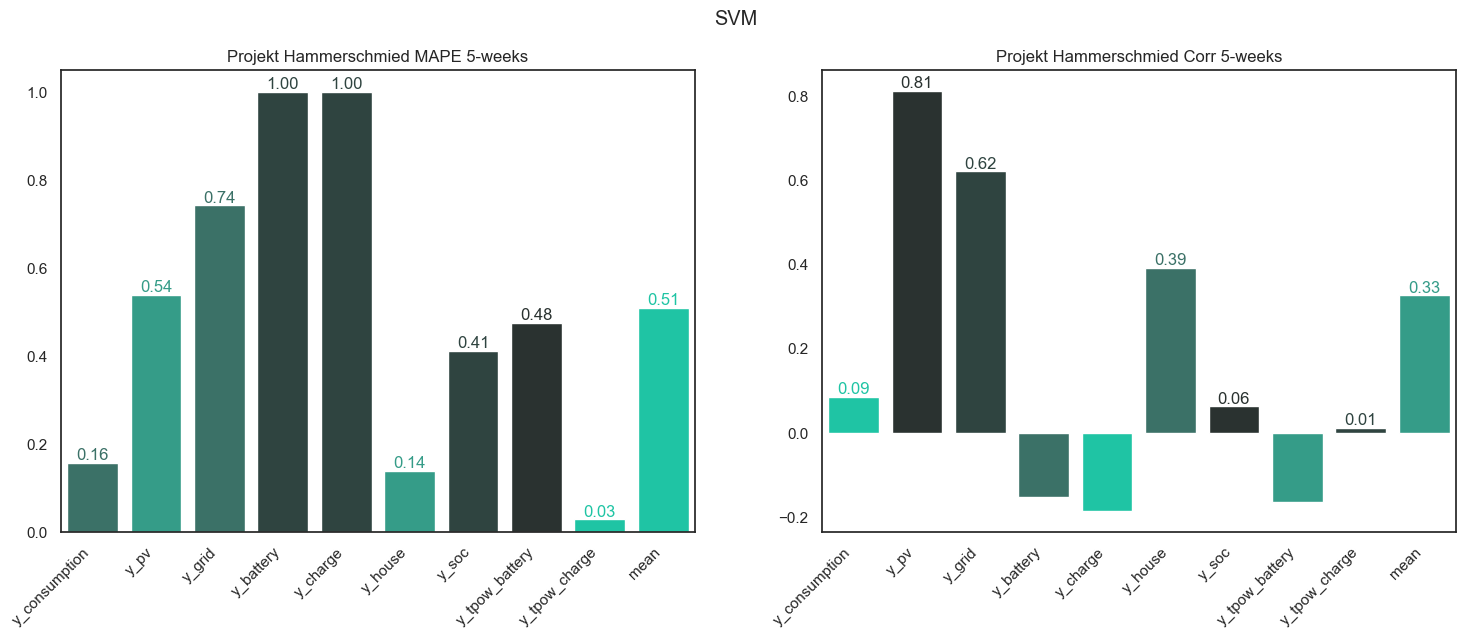

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

In [79]:
errors_svm = model_svm.evaluate(df_eval)
plot_svm = plot_errors(errors_svm, "SVM")

#### Elastic Net

In [80]:
from sklearn.linear_model import ElasticNet

# Fit model
model_elastic = EmsModel(custom_regressor=ElasticNet, custom_regressor_args={})
model_elastic.fit(x, y_consumption, y_pv, y_generator, y_grid, y_battery, y_charge,
            y_house, y_electric, y_pump, y_consumer, y_soc, y_tpow_battery,
            y_tpow_charge, y_tpow_electric, y_tpow_pump, y_tpow_consumer, recursive)

C:\Users\jpeff\AppData\Roaming\Python\Python311\site-packages\sklearn\linear_model\_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.096e+03, tolerance: 1.067e+01
  model = cd_fast.enet_coordinate_descent(
C:\Users\jpeff\AppData\Roaming\Python\Python311\site-packages\sklearn\linear_model\_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 7.028e+00, tolerance: 1.113e+00
  model = cd_fast.enet_coordinate_descent(
C:\Users\jpeff\AppData\Roaming\Python\Python311\site-packages\sklearn\linear_model\_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider in

C:\Users\jpeff\AppData\Local\Temp\ipykernel_38660\4003282145.py:53: UserWarning: 
The palette list has fewer values (5) than needed (7) and will cycle, which may produce an uninterpretable plot.
  ax = sns.barplot(x=model_names, ax=axes[i], y=errors, palette=palette, hue=errors)
C:\Users\jpeff\AppData\Local\Temp\ipykernel_38660\4003282145.py:55: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(ax.get_xticklabels(), rotation=45, horizontalalignment='right')
C:\Users\jpeff\AppData\Local\Temp\ipykernel_38660\4003282145.py:53: UserWarning: 
The palette list has fewer values (5) than needed (10) and will cycle, which may produce an uninterpretable plot.
  ax = sns.barplot(x=model_names, ax=axes[i], y=errors, palette=palette, hue=errors)
C:\Users\jpeff\AppData\Local\Temp\ipykernel_38660\4003282145.py:55: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after

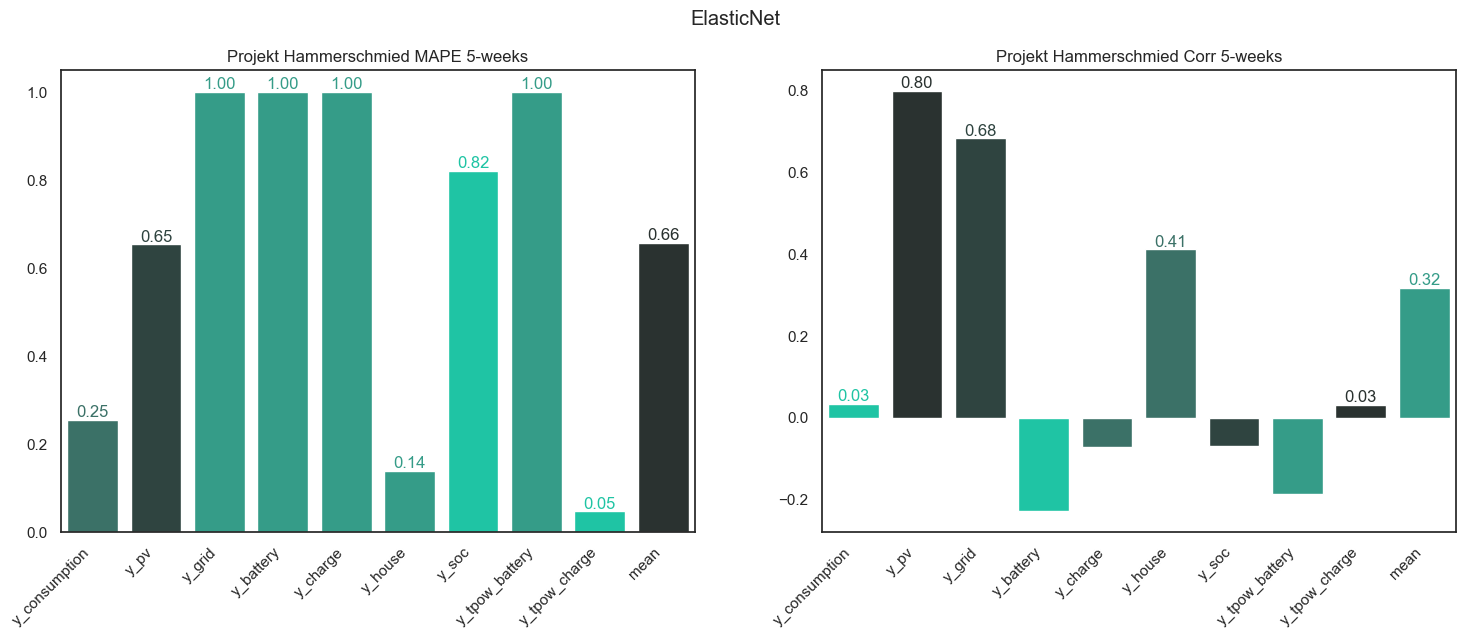

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

In [81]:
errors_elastic = model_elastic.evaluate(df_eval)
plot_elastic = plot_errors(errors_elastic, "ElasticNet")

#### Linear Regression

In [82]:
from sklearn.linear_model import LinearRegression

# Fit model
model_lr = EmsModel(custom_regressor=LinearRegression, custom_regressor_args=[])
model_lr.fit(x, y_consumption, y_pv, y_generator, y_grid, y_battery, y_charge,
            y_house, y_electric, y_pump, y_consumer, y_soc, y_tpow_battery,
            y_tpow_charge, y_tpow_electric, y_tpow_pump, y_tpow_consumer, recursive)

C:\Users\jpeff\AppData\Local\Temp\ipykernel_38660\4003282145.py:53: UserWarning: 
The palette list has fewer values (5) than needed (7) and will cycle, which may produce an uninterpretable plot.
  ax = sns.barplot(x=model_names, ax=axes[i], y=errors, palette=palette, hue=errors)
C:\Users\jpeff\AppData\Local\Temp\ipykernel_38660\4003282145.py:55: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(ax.get_xticklabels(), rotation=45, horizontalalignment='right')
C:\Users\jpeff\AppData\Local\Temp\ipykernel_38660\4003282145.py:53: UserWarning: 
The palette list has fewer values (5) than needed (10) and will cycle, which may produce an uninterpretable plot.
  ax = sns.barplot(x=model_names, ax=axes[i], y=errors, palette=palette, hue=errors)
C:\Users\jpeff\AppData\Local\Temp\ipykernel_38660\4003282145.py:55: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after

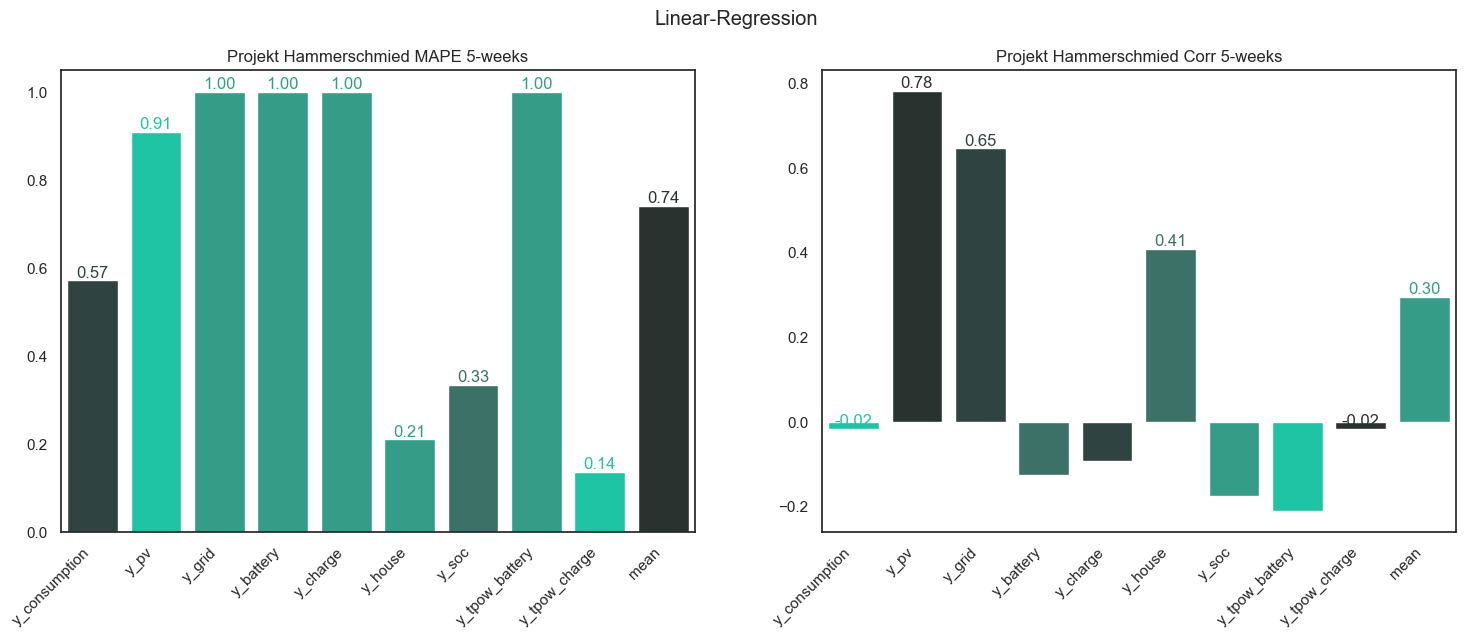

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

In [83]:
errors_lr = model_lr.evaluate(df_eval)
plot_lr = plot_errors(errors_lr, "Linear-Regression")

#### ARIMA

In [ ]:
!pip install pmdarima


[notice] A new release of pip available: 22.3.1 -> 23.3.2
[notice] To update, run: python.exe -m pip install --upgrade pip



  Using cached pmdarima-2.0.4-cp311-cp311-win_amd64.whl (614 kB)
  Using cached statsmodels-0.14.1-cp311-cp311-win_amd64.whl (9.9 MB)


In [ ]:
from pmdarima import arima
from ai.interface.model import Model

class EMSArima(Model):
    def fit(self, x,y):
        model = arima.AutoARIMA()
        model.fit(y)
        self.model = model
    def predict(self, x):
        return self.model.predict(n_periods=len(df_eval))

model_arima = EmsModel(custom_regressor=EMSArima, custom_regressor_args=[])

model_arima.fit(x, y_consumption, y_pv, y_generator, y_grid, y_battery, y_charge,
            y_house, y_electric, y_pump, y_consumer, y_soc, y_tpow_battery,
            y_tpow_charge, y_tpow_electric, y_tpow_pump, y_tpow_consumer, recursive)


In [ ]:
len(df_eval)

672

In [ ]:
preds = model_arima.predict(df_eval)


c:\Users\jpeff\Documents\GitHub\efficientIO\ai\model\ems_model.py:182: RuntimeWarning: invalid value encountered in greater
  y_pv.append(p * (p > 0.3))
c:\Users\jpeff\Documents\GitHub\efficientIO\ai\model\ems_model.py:182: RuntimeWarning: invalid value encountered in greater
  y_pv.append(p * (p > 0.3))
c:\Users\jpeff\Documents\GitHub\efficientIO\ai\model\ems_model.py:182: RuntimeWarning: invalid value encountered in greater
  y_pv.append(p * (p > 0.3))
c:\Users\jpeff\Documents\GitHub\efficientIO\ai\model\ems_model.py:182: RuntimeWarning: invalid value encountered in greater
  y_pv.append(p * (p > 0.3))


In [ ]:
(y_consumption_pred, y_pv_pred, y_generator_pred, y_grid_pred, y_battery_pred, y_charge_pred,
         y_house_pred, y_electric_pred, y_pump_pred, y_consumer_pred, y_soc_pred, y_tpow_battery_pred,
         y_tpow_charge_pred, y_tpow_electric_pred, y_tpow_pump_pred, y_tpow_consumer_pred) =  preds

In [ ]:
len(y_pv_pred)

4

In [ ]:
len(pd.DataFrame(y_generator_pred).dropna())

0

In [ ]:
errors_arima = model_arima.evaluate(df_eval)
plot_arima = plot_errors(errors_arima, "ARIMA")

InvalidParameterError: The 'y_pred' parameter of mean_absolute_percentage_error must be an array-like. Got 7.538007467649984 instead.

### Testing Pipeline

In [ ]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import MinMaxScaler

# Fit model
model_std_svr = EmsModel(custom_regressor=Pipeline, custom_regressor_args={"steps":[("scaler", MinMaxScaler()),("svr",svm.SVR())]})

model_std_svr.fit(x, y_consumption, y_pv, y_generator, y_grid, y_battery, y_charge,
            y_house, y_electric, y_pump, y_consumer, y_soc, y_tpow_battery,
            y_tpow_charge, y_tpow_electric, y_tpow_pump, y_tpow_consumer, recursive)

In [ ]:
df_preprocessed_for_prediction = preprocess_ems_data(df_eval, 15, True)
(x_pred, y_consumption_actual, y_pv_actual, _, y_grid_actual, y_battery_actual,
    y_charge_actual, _, _,_, _, y_soc_actual,_, _, _, _,
    _, recursive) = get_ems_features(
    df_preprocessed_for_prediction,
    lag_steps=[15, 30, 45, 60],
    prediction_steps=[15, 30, 45, 60],
    time_resolution=15,
    lag_label=[15])
(y_consumption_pred, y_pv_pred, y_generator_pred, y_grid_pred, y_battery_pred, y_charge_pred,
         y_house_pred, y_electric_pred, y_pump_pred, y_consumer_pred, y_soc_pred, y_tpow_battery_pred,
         y_tpow_charge_pred, y_tpow_electric_pred, y_tpow_pump_pred, y_tpow_consumer_pred)= model_svm.predict(x_pred)

y_consumption_pred.max()

6.089468278187749

In [ ]:
pv_frame = pd.DataFrame(y_soc_actual).transpose()
pv_frame.columns = ["Actual"]
pv_frame

,Actual
ts,
2024-01-17 12:30:00+01:00,35.0
2024-01-17 12:45:00+01:00,35.0
2024-01-17 13:00:00+01:00,35.0
2024-01-17 13:15:00+01:00,35.0
2024-01-17 13:30:00+01:00,35.0
...,...
2024-01-24 09:15:00+01:00,96.0
2024-01-24 09:30:00+01:00,96.0
2024-01-24 09:45:00+01:00,96.0


<Axes: xlabel='ts'>

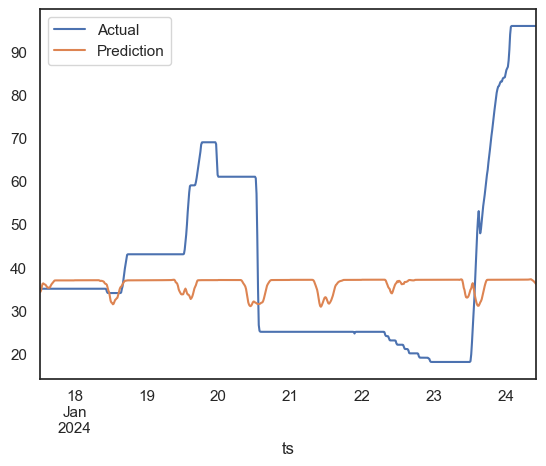

In [ ]:
pv_frame["Prediction"] = y_soc_pred[0]
pv_frame.plot()


C:\Users\jpeff\AppData\Roaming\Python\Python311\site-packages\numpy\lib\function_base.py:2897: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
C:\Users\jpeff\AppData\Roaming\Python\Python311\site-packages\numpy\lib\function_base.py:2898: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]
C:\Users\jpeff\AppData\Local\Temp\ipykernel_32596\1776157250.py:65: UserWarning: The palette list has more values (5) than needed (4), which may not be intended.
  ax = sns.barplot(x=model_names, ax=axes[i], y=errors, palette=palette, hue=errors)
C:\Users\jpeff\AppData\Local\Temp\ipykernel_32596\1776157250.py:67: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(ax.get_xticklabels(), rotation=45, horizontalalignment='right')
C:\Users\jpeff\AppData\Local\Temp\ipykernel_32596\1776157250.py:65: UserWarning: 
The palette list has fewer values (5) than needed 

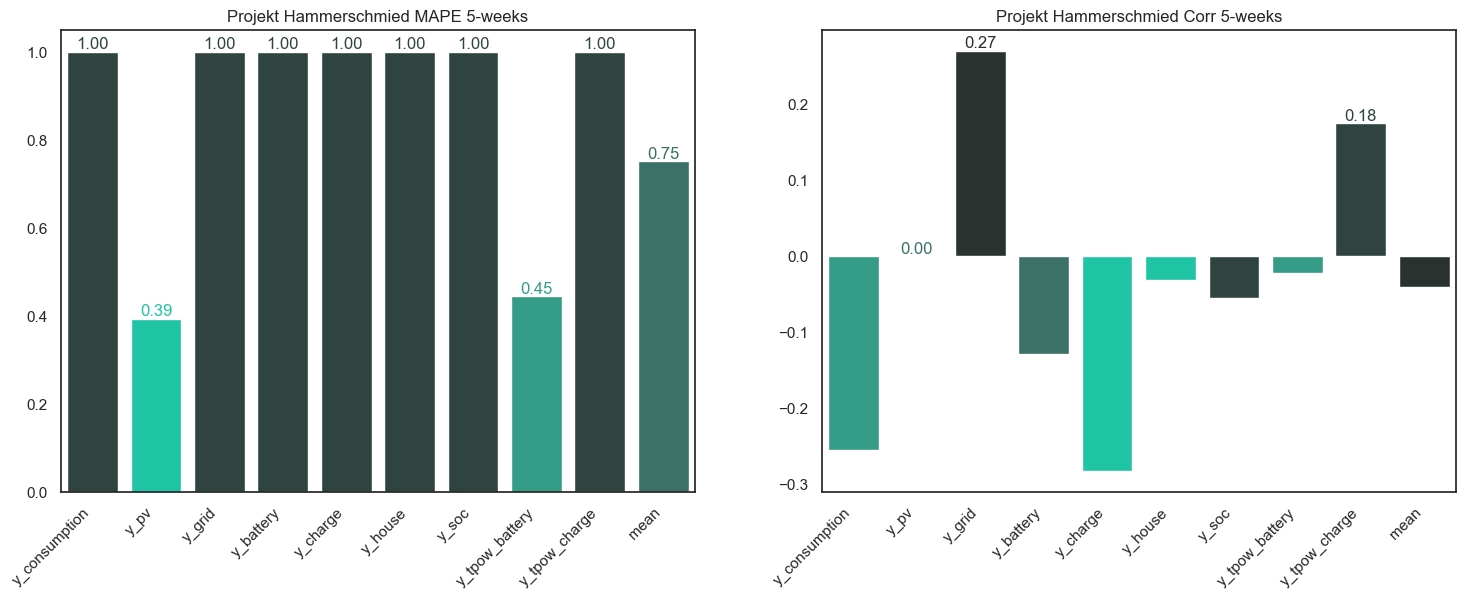

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

In [ ]:
errors_std_svr = model_std_svr.evaluate(df_eval)
plot_std_svr = plot_errors(errors_std_svr, "SVR-Pipeline")

### THE END (more or less)

exception to stop notebook here

In [ ]:
raise Exception()

Exception: 

### Sanity Check

In [ ]:
model_rf.fit(x, y_consumption, y_pv, y_generator, y_grid, y_battery, y_charge,
            y_house, y_electric, y_pump, y_consumer, y_soc, y_tpow_battery,
            y_tpow_charge, y_tpow_electric, y_tpow_pump, y_tpow_consumer, recursive)

Fitting RecursiveRandomForest
Fittings RF Recursifly
Fitting RecursiveRandomForest
Fittings RF Recursifly
Fitting RecursiveRandomForest
Fittings RF Recursifly
Fitting RecursiveRandomForest
Fittings RF Recursifly
Fitting RecursiveRandomForest
Fittings RF Recursifly
Fitting RecursiveRandomForest
Fittings RF Recursifly
Fitting RecursiveRandomForest
Fittings RF Recursifly
Fitting RecursiveRandomForest
Fittings RF Recursifly
Fitting RecursiveRandomForest
Fittings RF Recursifly
Fitting RecursiveRandomForest
Fittings RF Recursifly
Fitting RecursiveRandomForest
Fittings RF Recursifly
Fitting RecursiveRandomForest
Fittings RF Recursifly


C:\Users\jpeff\AppData\Local\Temp\ipykernel_42136\3990312490.py:123: UserWarning: 
The palette list has fewer values (5) than needed (8) and will cycle, which may produce an uninterpretable plot.
  ax = sns.barplot(x=model_names, ax=axes[i], y=errors, palette=palette, hue=errors)
C:\Users\jpeff\AppData\Local\Temp\ipykernel_42136\3990312490.py:125: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(ax.get_xticklabels(), rotation=45, horizontalalignment='right')
C:\Users\jpeff\AppData\Local\Temp\ipykernel_42136\3990312490.py:123: UserWarning: 
The palette list has fewer values (5) than needed (10) and will cycle, which may produce an uninterpretable plot.
  ax = sns.barplot(x=model_names, ax=axes[i], y=errors, palette=palette, hue=errors)
C:\Users\jpeff\AppData\Local\Temp\ipykernel_42136\3990312490.py:125: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. a

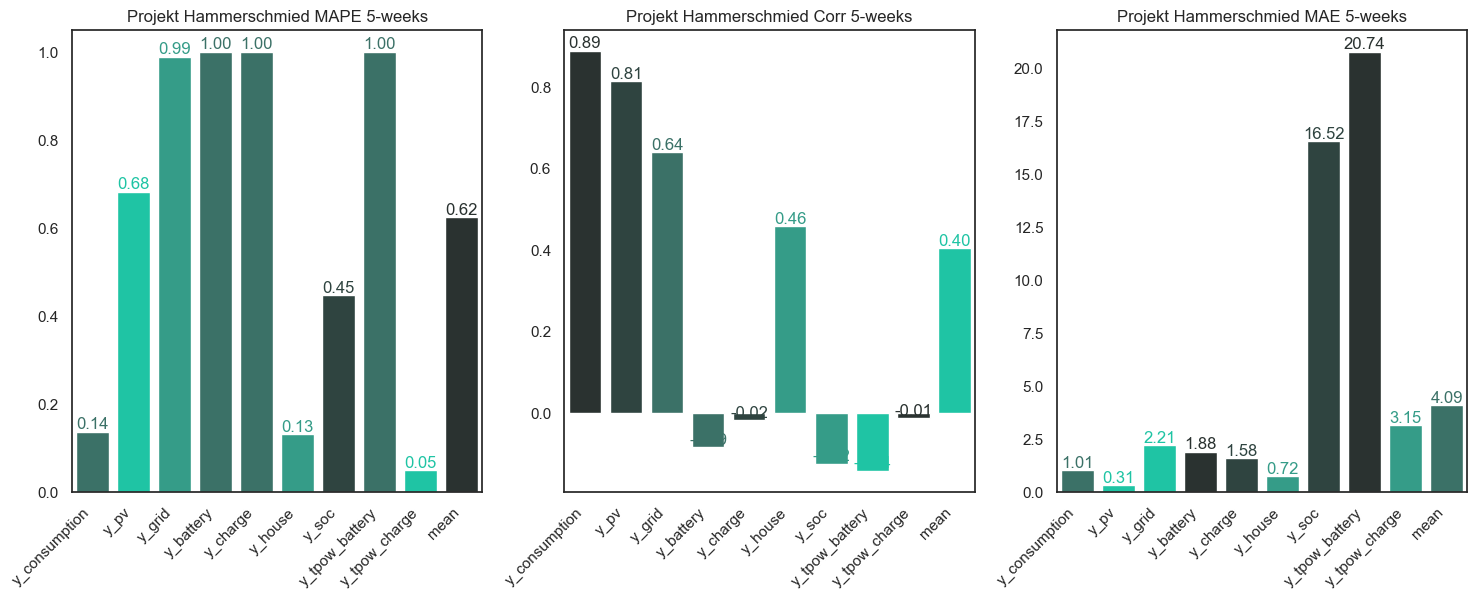

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

In [ ]:
# create test set and predict

df_test = model_holder.get_dh().get_data(int(end_training.timestamp()), int(end.timestamp()))
df_test = preprocess_ems_data(df_test, 15, True)

(x, y_consumption, y_pv, y_generator, y_grid, y_battery,
    y_charge, y_house, y_electric, y_pump, y_consumer,
    y_soc, y_tpow_battery, y_tpow_charge, y_tpow_electric, y_tpow_pump,
    y_tpow_consumer, recursive) = get_ems_features(
    df_test,
    lag_steps=[15, 30, 45, 60],
    prediction_steps=[15, 30, 45, 60],
    time_resolution=15,
    lag_label=[15])
    
(y_consumption_pred, y_pv_pred, y_generator_pred, y_grid_pred, y_battery_pred, y_charge_pred,
    y_house_pred, y_electric_pred, y_pump_pred, y_consumer_pred, y_soc_pred, y_tpow_battery_pred,
    y_tpow_charge_pred, y_tpow_electric_pred, y_tpow_pump_pred, y_tpow_consumer_pred) = model_rf.predict(x, recursive)
    
from sklearn.metrics import mean_absolute_error, mean_absolute_percentage_error, mean_squared_error, r2_score
import numpy as np

# prepare error calcs
pairs = {
    "y_consumption":(y_consumption,y_consumption_pred),
    "y_pv":(y_pv,y_pv_pred),
    "y_generator":(y_generator,y_generator_pred),
    "y_grid":(y_grid,y_grid_pred),
    "y_battery":(y_battery,y_battery_pred),
    "y_charge":(y_charge,y_charge_pred),
    "y_house":(y_house,y_house_pred),
    "y_electric":(y_electric,y_electric_pred),
    "y_pump":(y_pump,y_pump_pred),
    "y_consumer":(y_consumer,y_consumer_pred),
    "y_soc":(y_soc,y_soc_pred),
    "y_tpow_battery":(y_tpow_battery,y_tpow_battery_pred),
    "y_tpow_charge":(y_tpow_charge,y_tpow_charge_pred),
    "y_tpow_electric":(y_tpow_electric,y_tpow_electric_pred),
    "y_tpow_pump":(y_tpow_pump,y_tpow_pump_pred),
    "y_tpow_consumer":(y_tpow_consumer,y_tpow_consumer_pred)
    }
    
metrics = {
    "MAPE": {"metric": mean_absolute_percentage_error, "limit": 1},
    "Corr": {"metric": np.corrcoef},
    "MAE": {"metric": mean_absolute_error},
    # "R2": {"metric": r2_score} prone to outliers
    
    }    



# Calc error measures
error_dict = dict()
for mkey, mval in metrics.items():
    model_errors = pairs.copy()
    mean = 0
    count = 0

    for key, val in model_errors.items():
        if len(val[0]) == 0:
            model_errors[key] = -99
        else:
            if key != "y_consumption":
                error = 0
                instance_count = 0
                for instance in range(0, len(val[0])):
                    count+=1
                    instance_count += 1
                    er = mval["metric"](val[0][instance], val[1][instance])
                    if mkey == "Corr":
                        er = er[0,1]
                    
                    if "limit" in mval.keys():
                        if er > mval["limit"]:
                            er = mval["limit"]
                    error+=er
                    mean+=er
                error = error/instance_count
            else:
                count+=1
                error = mval["metric"](val[0], val[1])
                if mkey == "Corr":
                        error = error[0,1]
                
                if "limit" in mval.keys():
                    if error > mval["limit"]:
                        error = mval["limit"]
                mean+=error

            model_errors[key] = error
    
    model_errors["mean"] = mean/count
            
    model_errors = {key: value for key, value in model_errors.items() if value != -99}
    error_dict[mkey] = model_errors


    import seaborn as sns
import matplotlib.pyplot as plt

# Plot errors

fig, axes = plt.subplots(nrows=1, ncols=len(error_dict), figsize=(18, 6), sharey=False)
for i, (key, value) in enumerate(error_dict.items()):
    
    # Extract keys and values from the dictionary
    model_names = list(value.keys())
    errors = list(value.values())

    # Create a bar chart using seaborn
    sns.set(style="white")
    plt.figure(figsize=(10, 6))
    axes[i].set_title(f'{model_df.iloc[index]["project_name"]} {key} {train_duration_weeks}-weeks')
    
    palette = [
'#03e0b5',
'#24AD92',
'#327A6C',
'#2C4742',
'#293331',]
    # You can customize the color palette if needed
    ax = sns.barplot(x=model_names, ax=axes[i], y=errors, palette=palette, hue=errors)
    ax.legend_.remove()
    ax.set_xticklabels(ax.get_xticklabels(), rotation=45, horizontalalignment='right')
    for p in ax.patches:
        if p.get_width() == p.get_height() == 0:
            continue
        
        ax.text(p.get_x() + p.get_width()/2., p.get_height(), '{0:.2f}'.format(p.get_height()), 
        fontsize=12, color=p.get_facecolor(), ha='center', va='bottom')

fig.savefig(f"XGBOOST{model_df.iloc[index]['project_name']}_{model_df.iloc[index]['model_id']}_dur-{train_duration_weeks}.png")


### OLD

In [ ]:
# create test set and predict

df_test = model_holder.get_dh().get_data(int(end_training.timestamp()), int(end.timestamp()))
df_test = preprocess_ems_data(df_test, 15, True)

(x, y_consumption, y_pv, y_generator, y_grid, y_battery,
    y_charge, y_house, y_electric, y_pump, y_consumer,
    y_soc, y_tpow_battery, y_tpow_charge, y_tpow_electric, y_tpow_pump,
    y_tpow_consumer, recursive) = get_ems_features(
    df_test,
    lag_steps=[15, 30, 45, 60],
    prediction_steps=[15, 30, 45, 60],
    time_resolution=15,
    lag_label=[15])
    
(y_consumption_pred, y_pv_pred, y_generator_pred, y_grid_pred, y_battery_pred, y_charge_pred,
    y_house_pred, y_electric_pred, y_pump_pred, y_consumer_pred, y_soc_pred, y_tpow_battery_pred,
    y_tpow_charge_pred, y_tpow_electric_pred, y_tpow_pump_pred, y_tpow_consumer_pred) = model.predict(x, recursive)
    
from sklearn.metrics import mean_absolute_error, mean_absolute_percentage_error, mean_squared_error, r2_score
import numpy as np

# prepare error calcs
pairs = {
    "y_consumption":(y_consumption,y_consumption_pred),
    "y_pv":(y_pv,y_pv_pred),
    "y_generator":(y_generator,y_generator_pred),
    "y_grid":(y_grid,y_grid_pred),
    "y_battery":(y_battery,y_battery_pred),
    "y_charge":(y_charge,y_charge_pred),
    "y_house":(y_house,y_house_pred),
    "y_electric":(y_electric,y_electric_pred),
    "y_pump":(y_pump,y_pump_pred),
    "y_consumer":(y_consumer,y_consumer_pred),
    "y_soc":(y_soc,y_soc_pred),
    "y_tpow_battery":(y_tpow_battery,y_tpow_battery_pred),
    "y_tpow_charge":(y_tpow_charge,y_tpow_charge_pred),
    "y_tpow_electric":(y_tpow_electric,y_tpow_electric_pred),
    "y_tpow_pump":(y_tpow_pump,y_tpow_pump_pred),
    "y_tpow_consumer":(y_tpow_consumer,y_tpow_consumer_pred)
    }
    
metrics = {
    "MAPE": {"metric": mean_absolute_percentage_error, "limit": 1},
    "Corr": {"metric": np.corrcoef},
    "MAE": {"metric": mean_absolute_error},
    # "R2": {"metric": r2_score} prone to outliers
    
    }    

In [ ]:

# Calc error measures
error_dict = dict()
for mkey, mval in metrics.items():
    model_errors = pairs.copy()
    mean = 0
    count = 0

    for key, val in model_errors.items():
        if len(val[0]) == 0:
            model_errors[key] = -99
        else:
            if key != "y_consumption":
                error = 0
                instance_count = 0
                for instance in range(0, len(val[0])):
                    count+=1
                    instance_count += 1
                    er = mval["metric"](val[0][instance], val[1][instance])
                    if mkey == "Corr":
                        er = er[0,1]
                    
                    if "limit" in mval.keys():
                        if er > mval["limit"]:
                            er = mval["limit"]
                    error+=er
                    mean+=er
                error = error/instance_count
            else:
                count+=1
                error = mval["metric"](val[0], val[1])
                if mkey == "Corr":
                        error = error[0,1]
                
                if "limit" in mval.keys():
                    if error > mval["limit"]:
                        error = mval["limit"]
                mean+=error

            model_errors[key] = error
    
    model_errors["mean"] = mean/count
            
    model_errors = {key: value for key, value in model_errors.items() if value != -99}
    error_dict[mkey] = model_errors

C:\Users\jpeff\AppData\Local\Temp\ipykernel_36244\822438491.py:25: UserWarning: 
The palette list has fewer values (5) than needed (9) and will cycle, which may produce an uninterpretable plot.
  ax = sns.barplot(x=model_names, ax=axes[i], y=errors, palette=palette, hue=errors)
C:\Users\jpeff\AppData\Local\Temp\ipykernel_36244\822438491.py:27: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(ax.get_xticklabels(), rotation=45, horizontalalignment='right')
C:\Users\jpeff\AppData\Local\Temp\ipykernel_36244\822438491.py:25: UserWarning: 
The palette list has fewer values (5) than needed (10) and will cycle, which may produce an uninterpretable plot.
  ax = sns.barplot(x=model_names, ax=axes[i], y=errors, palette=palette, hue=errors)
C:\Users\jpeff\AppData\Local\Temp\ipykernel_36244\822438491.py:27: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set

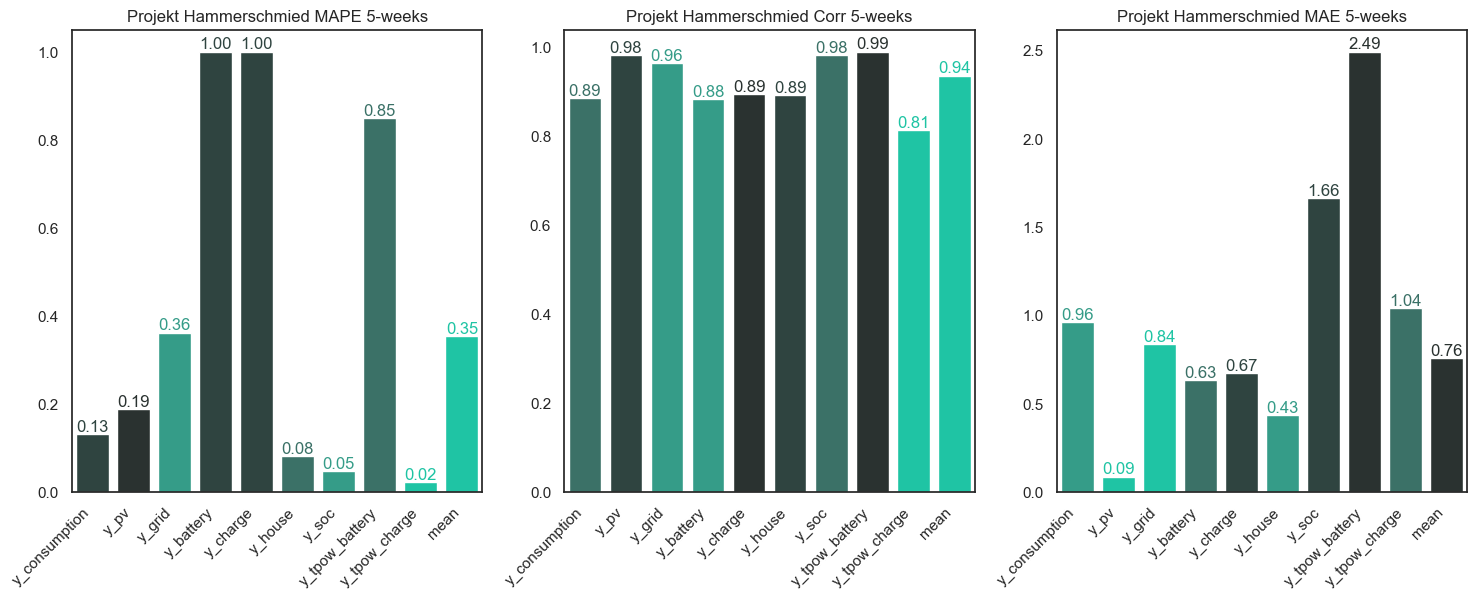

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

# Plot errors

fig, axes = plt.subplots(nrows=1, ncols=len(error_dict), figsize=(18, 6), sharey=False)
for i, (key, value) in enumerate(error_dict.items()):
    
    # Extract keys and values from the dictionary
    model_names = list(value.keys())
    errors = list(value.values())

    # Create a bar chart using seaborn
    sns.set(style="white")
    plt.figure(figsize=(10, 6))
    axes[i].set_title(f'{model_df.iloc[index]["project_name"]} {key} {train_duration_weeks}-weeks')
    
    palette = [
'#03e0b5',
'#24AD92',
'#327A6C',
'#2C4742',
'#293331',]
    # You can customize the color palette if needed
    ax = sns.barplot(x=model_names, ax=axes[i], y=errors, palette=palette, hue=errors)
    ax.legend_.remove()
    ax.set_xticklabels(ax.get_xticklabels(), rotation=45, horizontalalignment='right')
    for p in ax.patches:
        if p.get_width() == p.get_height() == 0:
            continue
        
        ax.text(p.get_x() + p.get_width()/2., p.get_height(), '{0:.2f}'.format(p.get_height()), 
        fontsize=12, color=p.get_facecolor(), ha='center', va='bottom')

fig.savefig(f"XGBOOST{model_df.iloc[index]['project_name']}_{model_df.iloc[index]['model_id']}_dur-{train_duration_weeks}.png")
